In [1]:
import warnings
warnings.filterwarnings('ignore')

### Find Cointegrated Pairs

In [2]:
import pandas as pd
from openbb import obb
obb.user.preferences.output_type = "dataframe"

In [3]:
# tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

import json

# 1. Open the file
with open("ticker_lists/ndx.json", "r", encoding="utf-8") as f:
    # 2. Parse the JSON
    tickers = json.load(f)      # <-- data is now a Python object
tickers.sort()

In [4]:
tickers

['AAPL',
 'ABNB',
 'ADBE',
 'ADI',
 'ADP',
 'ADSK',
 'AEP',
 'AMAT',
 'AMD',
 'AMGN',
 'AMZN',
 'APP',
 'ARM',
 'ASML',
 'AVGO',
 'AXON',
 'AZN',
 'BIIB',
 'BKNG',
 'BKR',
 'CCEP',
 'CDNS',
 'CDW',
 'CEG',
 'CHTR',
 'CMCSA',
 'COST',
 'CPRT',
 'CRWD',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTSH',
 'DASH',
 'DDOG',
 'DXCM',
 'EA',
 'EXC',
 'FANG',
 'FAST',
 'FTNT',
 'GEHC',
 'GFS',
 'GILD',
 'GOOG',
 'GOOGL',
 'HON',
 'IDXX',
 'INTC',
 'INTU',
 'ISRG',
 'KDP',
 'KHC',
 'KLAC',
 'LIN',
 'LRCX',
 'LULU',
 'MAR',
 'MCHP',
 'MDLZ',
 'MELI',
 'META',
 'MNST',
 'MRVL',
 'MSFT',
 'MSTR',
 'MU',
 'NFLX',
 'NVDA',
 'NXPI',
 'ODFL',
 'ON',
 'ORLY',
 'PANW',
 'PAYX',
 'PCAR',
 'PDD',
 'PEP',
 'PLTR',
 'PYPL',
 'QCOM',
 'REGN',
 'ROP',
 'ROST',
 'SBUX',
 'SHOP',
 'SNPS',
 'TEAM',
 'TMUS',
 'TRI',
 'TSLA',
 'TTD',
 'TTWO',
 'TXN',
 'VRSK',
 'VRTX',
 'WBD',
 'WDAY',
 'XEL',
 'ZS']

In [5]:
start_date="2020-01-01"
end_date="2025-01-01"

In [6]:
from __future__ import annotations
import pandas as pd
import logging
from pandas.errors import EmptyDataError
from typing import Iterable, List, Tuple, Union, Optional

def download_history_openbb(
    tickers: Union[Iterable[str], pd.Series, pd.Index],
    start_date: Union[str, pd.Timestamp],
    end_date:   Union[str, pd.Timestamp],
    *,
    provider: str = "yfinance",
    show_progress: bool = True,
    silence_logs: bool = True,
    return_failed: bool = False,
):
    """
    Download historical OHLCV for multiple tickers via OpenBB and stitch into one DataFrame.

    Returns:
        df                      (pd.DataFrame): concatenated results with a 'ticker' column.
        (optionally) failed     (List[str])   : tickers that returned no data or errored.

    Notes:
    - `tickers` can be any iterable of strings (duplicates/NaNs ignored).
    - `start_date`/`end_date` accept 'YYYY-MM-DD' or pandas Timestamps.
    """
    # Lazy imports inside so the function is standalone
    from tqdm import tqdm
    try:
        from openbb import obb  # OpenBB v4
    except Exception as e:
        raise ImportError("OpenBB not available. `pip install openbb` (v4).") from e

    # Silence noisy logs if requested
    if silence_logs:
        for lg in ["openbb_core", "openbb_yfinance", "openbb", "yfinance"]:
            logging.getLogger(lg).setLevel(logging.CRITICAL)

    # Clean ticker list
    tickers = pd.Index(pd.Series(list(tickers), dtype="object")).dropna().astype(str).unique().tolist()

    frames: List[pd.DataFrame] = []
    failed: List[str] = []

    iterator = tqdm(tickers, desc="Download", disable=not show_progress)
    for tkr in iterator:
        if show_progress:
            iterator.set_description(tkr)
        try:
            df_new = obb.equity.price.historical(
                symbol=tkr,
                start_date=start_date,
                end_date=end_date,
                provider=provider,
            )
            # OpenBB returns a DataFrame (DatetimeIndex). Guard against empties/None.
            if df_new is None or len(df_new) == 0:
                failed.append(tkr)
                continue
            df_new = df_new.copy()
            df_new["ticker"] = tkr
            frames.append(df_new)
        except (EmptyDataError, Exception):
            failed.append(tkr)

    # Stitch results (avoid concat on empty list)
    if frames:
        df = pd.concat(frames, ignore_index=False)
    else:
        df = pd.DataFrame(columns=["open", "high", "low", "close", "adj_close", "volume", "ticker"])

    if return_failed:
        return df, failed
    return df


In [7]:
df, failed = download_history_openbb(tickers, start_date, end_date, return_failed=True)

print(df.head())
if failed:
    print("No data for:", failed)

ZS: 100%|██████████| 101/101 [00:27<00:00,  3.67it/s]  

                 open       high        low      close     volume  \
date                                                                
2020-01-02  74.059998  75.150002  73.797501  75.087502  135480400   
2020-01-03  74.287498  75.144997  74.125000  74.357498  146322800   
2020-01-06  73.447502  74.989998  73.187500  74.949997  118387200   
2020-01-07  74.959999  75.224998  74.370003  74.597504  108872000   
2020-01-08  74.290001  76.110001  74.290001  75.797501  132079200   

            split_ratio  dividend ticker  
date                                      
2020-01-02          0.0       0.0   AAPL  
2020-01-03          0.0       0.0   AAPL  
2020-01-06          0.0       0.0   AAPL  
2020-01-07          0.0       0.0   AAPL  
2020-01-08          0.0       0.0   AAPL  


In [8]:
df

,open,high,low,close,volume,split_ratio,dividend,ticker
date,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,135480400,0.0,0.0,AAPL
2020-01-03,74.287498,75.144997,74.125000,74.357498,146322800,0.0,0.0,AAPL
2020-01-06,73.447502,74.989998,73.187500,74.949997,118387200,0.0,0.0,AAPL
2020-01-07,74.959999,75.224998,74.370003,74.597504,108872000,0.0,0.0,AAPL
2020-01-08,74.290001,76.110001,74.290001,75.797501,132079200,0.0,0.0,AAPL
...,...,...,...,...,...,...,...,...
2024-12-24,185.979996,187.589996,184.679993,187.259995,654200,NaN,NaN,ZS
2024-12-26,186.000000,188.500000,185.869995,187.630005,806500,NaN,NaN,ZS
2024-12-27,185.259995,185.929993,181.259995,184.559998,1256100,NaN,NaN,ZS


In [9]:
df.index.unique().min(), df.index.unique().max()

(datetime.date(2020, 1, 2), datetime.date(2024, 12, 31))

### Pre-filter for Liquidity & Data Quality

In [10]:
for ticker in tickers:
    if df[df['ticker']==ticker].index.min()!=df.index.unique().min() or df[df['ticker']==ticker].index.max()!=df.index.unique().max():
        df = df[df['ticker']!=ticker]

In [11]:
len(df['ticker'].unique())

93

In [12]:
set(tickers) - set(df['ticker'].unique())

{'ABNB', 'APP', 'ARM', 'CEG', 'DASH', 'GEHC', 'GFS', 'PLTR'}

In [13]:
df

,open,high,low,close,volume,split_ratio,dividend,ticker
date,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,135480400,0.0,0.0,AAPL
2020-01-03,74.287498,75.144997,74.125000,74.357498,146322800,0.0,0.0,AAPL
2020-01-06,73.447502,74.989998,73.187500,74.949997,118387200,0.0,0.0,AAPL
2020-01-07,74.959999,75.224998,74.370003,74.597504,108872000,0.0,0.0,AAPL
2020-01-08,74.290001,76.110001,74.290001,75.797501,132079200,0.0,0.0,AAPL
...,...,...,...,...,...,...,...,...
2024-12-24,185.979996,187.589996,184.679993,187.259995,654200,NaN,NaN,ZS
2024-12-26,186.000000,188.500000,185.869995,187.630005,806500,NaN,NaN,ZS
2024-12-27,185.259995,185.929993,181.259995,184.559998,1256100,NaN,NaN,ZS


### Initial Cointegration Screening
 - Engle-Granger test, or
 - Johansen test

In [14]:
from itertools import combinations
from typing import Literal, Optional
import os, numpy as np, pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from joblib import Parallel, delayed
from tqdm import tqdm
import joblib
from contextlib import contextmanager

# ---------- progress helper for joblib + tqdm ----------
@contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar."""
    class TqdmBatchCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

# ---------- small utils ----------
def _align_dropna(S1: pd.Series, S2: pd.Series) -> pd.DataFrame:
    """Align two series on their shared index and drop internal NaNs."""
    df = pd.concat([S1, S2], axis=1, keys=["S1", "S2"]).dropna()
    return df

def _alpha_to_col(alpha: float) -> int:
    """
    Johansen critical values matrix has columns for [90%, 95%, 99%].
    Map alpha to the closest supported level.
    """
    if alpha <= 0.01:
        return 2
    if alpha <= 0.05:
        return 1
    if alpha <= 0.10:
        return 0
    # default to 5% if something unusual is passed
    return 1

# ------------- EG helper ------------- #
def _test_pair_eg(idx_pair, *, keys, data, full_start, full_end, alpha,
                  trend: str = "c", maxlag: Optional[int] = None, autolag: str = "aic"):
    i, j = idx_pair
    k1, k2 = keys[i], keys[j]
    S1 = data.loc[data["ticker"] == k1, "close"]
    S2 = data.loc[data["ticker"] == k2, "close"]

    # Keep your full-span requirement
    if not (S1.index[0] == full_start and S1.index[-1] == full_end and
            S2.index[0] == full_start and S2.index[-1] == full_end):
        return i, j, 0.0, np.nan, False

    df = _align_dropna(S1, S2)
    if len(df) < 50:
        return i, j, 0.0, np.nan, False

    # statsmodels.coint does EG 2-step internally
    tstat, pval, _ = coint(df["S1"], df["S2"], trend=trend, maxlag=maxlag, autolag=autolag)
    is_coint = bool(pval < alpha)
    return i, j, float(tstat), float(pval), is_coint

# ------------- Johansen helper ------------- #
def _test_pair_johansen(idx_pair, *, keys, data, full_start, full_end, alpha,
                        det_order: int = 0, k_ar_diff: int = 1, stat: Literal["trace", "maxeig"] = "trace"):
    """
    For a pair (2 variables), reject H0: r=0 if the chosen statistic exceeds its critical value.
    det_order and k_ar_diff are passed to statsmodels.coint_johansen.
    """
    i, j = idx_pair
    k1, k2 = keys[i], keys[j]
    S1 = data.loc[data["ticker"] == k1, "close"]
    S2 = data.loc[data["ticker"] == k2, "close"]

    if not (S1.index[0] == full_start and S1.index[-1] == full_end and
            S2.index[0] == full_start and S2.index[-1] == full_end):
        return i, j, 0.0, np.nan, False

    df = _align_dropna(S1, S2)
    if len(df) < 50:
        return i, j, 0.0, np.nan, False

    X = df[["S1", "S2"]].values
    res = coint_johansen(X, det_order=det_order, k_ar_diff=k_ar_diff)

    # Choose statistic & corresponding critical values
    alpha_col = _alpha_to_col(alpha)
    if stat == "trace":
        test_stat = float(res.lr1[0])        # trace statistic for r=0
        crit_val  = float(res.cvt[0, alpha_col])  # 90/95/99% critical values
    else:
        test_stat = float(res.lr2[0])        # max eigen statistic for r=0->1
        crit_val  = float(res.cvm[0, alpha_col])

    is_coint = bool(test_stat > crit_val)

    # No p-value readily available; store NaN in pvalue_matrix
    return i, j, test_stat, np.nan, is_coint

# ------------- main API ------------ #
def find_cointegrated_pairs_joblib(
    data: pd.DataFrame,
    *,
    alpha: float = 0.05,
    method: Literal["eg", "johansen"] = "eg",
    # EG options
    eg_trend: str = "c",
    eg_maxlag: Optional[int] = None,
    eg_autolag: str = "aic",
    # Johansen options
    joh_det_order: int = 0,
    joh_k_ar_diff: int = 1,
    joh_stat: Literal["trace", "maxeig"] = "trace",
    # parallelism
    n_workers: int | None = None,
    chunksize: int = 250,          # joblib batch_size
    show_progress: bool = True,
):
    """
    Scan all ticker pairs for cointegration using either Engle–Granger or Johansen.

    Returns:
        score_matrix: (n x n) matrix of test statistics (EG t-stat or Johansen chosen stat)
        pvalue_matrix: (n x n) matrix of p-values (EG) or NaN (Johansen)
        pairs: list of (ticker_i, ticker_j) that pass the chosen test at 'alpha'
    """
    # Keep BLAS libs from oversubscribing threads; children inherit env
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS",      "1")
    os.environ.setdefault("NUMEXPR_NUM_THREADS",  "1")

    keys = np.asarray(data["ticker"].unique())
    n    = len(keys)
    score_matrix  = np.zeros((n, n))
    pvalue_matrix = np.full((n, n), np.nan)
    pairs         = []

    full_start, full_end = data.index.min(), data.index.max()
    combos     = list(combinations(range(n), 2))
    n_workers  = n_workers or os.cpu_count()

    # Choose worker and description text
    if method == "eg":
        worker = lambda idx_pair: _test_pair_eg(
            idx_pair,
            keys=keys, data=data, full_start=full_start, full_end=full_end, alpha=alpha,
            trend=eg_trend, maxlag=eg_maxlag, autolag=eg_autolag
        )
        desc_text = "Engle-Granger cointegration tests"
    elif method == "johansen":
        worker = lambda idx_pair: _test_pair_johansen(
            idx_pair,
            keys=keys, data=data, full_start=full_start, full_end=full_end, alpha=alpha,
            det_order=joh_det_order, k_ar_diff=joh_k_ar_diff, stat=joh_stat
        )
        desc_text = "Johansen cointegration tests"
    else:
        raise ValueError("method must be 'eg' or 'johansen'")

    iterator = (delayed(worker)(idx_pair) for idx_pair in combos)

    if show_progress:
        with tqdm_joblib(tqdm(total=len(combos), desc=desc_text, leave=False)):
            results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)
    else:
        results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)

    for i, j, score, pval, is_coint in results:
        k1, k2 = keys[i], keys[j]
        score_matrix[i, j]  = score
        pvalue_matrix[i, j] = pval
        if is_coint:
            pairs.append((k1, k2))

    return score_matrix, pvalue_matrix, pairs


In [15]:
# Engle–Granger (default)
score_m, pval_m, pairs_eg = find_cointegrated_pairs_joblib(df, alpha=0.05, method="eg")

Engle-Granger cointegration tests:   0%|          | 0/4278 [00:00<?, ?it/s]

In [16]:
# Johansen, trace statistic at 5%, 1 lag difference, constant in the relation (det_order=0)
score_m, pval_m, pairs_j = find_cointegrated_pairs_joblib(
    df, alpha=0.05, method="johansen", joh_stat="trace", joh_k_ar_diff=1, joh_det_order=0
)

Johansen cointegration tests:   0%|          | 0/4278 [00:00<?, ?it/s]

In [17]:
from pprint import pprint
pprint(pairs_eg)

[('AAPL', 'BKR'),
 ('AAPL', 'MAR'),
 ('AAPL', 'PANW'),
 ('ADI', 'BKR'),
 ('ADI', 'CCEP'),
 ('ADI', 'LIN'),
 ('ADI', 'MAR'),
 ('ADI', 'MSFT'),
 ('ADI', 'ORLY'),
 ('ADI', 'PANW'),
 ('ADI', 'ROP'),
 ('ADI', 'TRI'),
 ('ADP', 'BKR'),
 ('ADP', 'FTNT'),
 ('ADSK', 'EA'),
 ('ADSK', 'SHOP'),
 ('ADSK', 'TTWO'),
 ('AEP', 'AMAT'),
 ('AEP', 'AMD'),
 ('AEP', 'AMGN'),
 ('AEP', 'AMZN'),
 ('AEP', 'ASML'),
 ('AEP', 'AVGO'),
 ('AEP', 'AXON'),
 ('AEP', 'AZN'),
 ('AEP', 'BIIB'),
 ('AEP', 'BKNG'),
 ('AEP', 'BKR'),
 ('AEP', 'CDNS'),
 ('AEP', 'CDW'),
 ('AEP', 'CHTR'),
 ('AEP', 'CMCSA'),
 ('AEP', 'COST'),
 ('AEP', 'CPRT'),
 ('AEP', 'CRWD'),
 ('AEP', 'CSCO'),
 ('AEP', 'CSGP'),
 ('AEP', 'CSX'),
 ('AEP', 'CTAS'),
 ('AEP', 'CTSH'),
 ('AEP', 'DDOG'),
 ('AEP', 'DXCM'),
 ('AEP', 'EA'),
 ('AEP', 'EXC'),
 ('AEP', 'FANG'),
 ('AEP', 'FAST'),
 ('AEP', 'FTNT'),
 ('AEP', 'GILD'),
 ('AEP', 'IDXX'),
 ('AEP', 'INTC'),
 ('AEP', 'INTU'),
 ('AEP', 'ISRG'),
 ('AEP', 'KDP'),
 ('AEP', 'KLAC'),
 ('AEP', 'LRCX'),
 ('AEP', 'LULU'),
 ('A

### Apply Kalman Filter to Estimate $\alpha_t$ (intercept) and $\beta_t$ (Dynamic Hedge Ratio) and test $\varepsilon_t$ (spread) for stationarity

In [18]:
from itertools import combinations
from typing import Optional, Literal, Dict, Tuple, List
import os, numpy as np, pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import joblib
from contextlib import contextmanager

# pykalman
from pykalman import KalmanFilter

# ---------- progress helper for joblib + tqdm ----------
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

# ---------- helpers ----------
def _align_pair(data: pd.DataFrame, k1: str, k2: str) -> pd.DataFrame:
    s1 = data.loc[data["ticker"] == k1, "close"].rename("P1")
    s2 = data.loc[data["ticker"] == k2, "close"].rename("P2")
    df = pd.concat([s1, s2], axis=1).dropna()
    return df.astype(np.float64)

def _kalman_dynamic_hedge(
    k1: str,
    k2: str,
    df: pd.DataFrame,
    *,
    q: float = 1e-5,
    r: float = 1.0,
    init_cov: float = 1e6,
    mode: Literal["smooth", "filter"] = "smooth",
    em_iters: int = 0,
    return_params: bool = False,
):
    if df is None or len(df) < 5:
        return k1, k2, None, None

    y = df["P1"].values.reshape(-1, 1)
    x = df["P2"].values
    n = len(df)

    # H_t = [[x_t, 1]]
    H = np.zeros((n, 1, 2), dtype=np.float64)
    H[:, 0, 0] = x
    H[:, 0, 1] = 1.0
    F = np.eye(2, dtype=np.float64)

    kf = KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        initial_state_mean=np.array([0.0, 0.0], dtype=np.float64),   # [beta0, alpha0]
        initial_state_covariance=np.eye(2, dtype=np.float64) * init_cov,
        transition_covariance=np.eye(2, dtype=np.float64) * q,
        observation_covariance=np.array([[r]], dtype=np.float64),
    )

    if em_iters and em_iters > 0:
        kf = kf.em(y, n_iter=em_iters)  # learns Q,R (and possibly init covs)

    if mode == "smooth":
        state_means, state_covs = kf.smooth(y)
        # If we want to carry a FILTERED last state (recommended), re-run filter once:
        if return_params:
            f_means, f_covs = kf.filter(y)
            last_mean, last_cov = f_means[-1].copy(), f_covs[-1].copy()
    else:
        state_means, state_covs = kf.filter(y)
        last_mean, last_cov = state_means[-1].copy(), state_covs[-1].copy()

    beta_t  = state_means[:, 0]
    alpha_t = state_means[:, 1]
    y_hat   = alpha_t + beta_t * x
    resid   = df["P1"].values - y_hat

    states_df = pd.DataFrame(
        {"alpha": alpha_t, "beta": beta_t, "y_hat": y_hat, "resid": resid},
        index=df.index,
    )

    params = None
    if return_params:
        params = {
            "F": F.copy(),
            "Q": kf.transition_covariance.copy(),
            "R": kf.observation_covariance.copy(),
            "last_state_mean": last_mean,
            "last_state_cov": last_cov,
            "mode": mode,
            "em_iters": int(em_iters),
        }

    return k1, k2, states_df, params

# ---------- main API ----------
def kalman_dynamic_hedge_joblib(
    data: pd.DataFrame,
    pairs: Optional[List[Tuple[str, str]]] = None,
    *,
    q: float = 1e-5,
    r: float = 1.0,
    init_cov: float = 1e6,
    mode: Literal["smooth", "filter"] = "smooth",
    em_iters: int = 0,
    require_full_span: bool = False,
    n_workers: Optional[int] = None,
    chunksize: int = 100,
    show_progress: bool = True,
    return_params: bool = False,
):
    """
    Returns:
      - if return_params=False: dict[(k1,k2)] -> states DataFrame
      - if return_params=True : (states_dict, params_dict)
    """
    # Avoid BLAS oversubscription
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS",      "1")
    os.environ.setdefault("NUMEXPR_NUM_THREADS",  "1")

    keys = np.asarray(data["ticker"].unique())

    # Build the list of pairs to evaluate
    if pairs is None:
        idx_pairs = list(combinations(keys, 2))
    else:
        idx_pairs = list(pairs)

    if require_full_span:
        full_start, full_end = data.index.min(), data.index.max()
        def _full_span_ok(k):
            s = data.loc[data["ticker"] == k, "close"]
            return len(s) > 0 and s.index[0] == full_start and s.index[-1] == full_end
        idx_pairs = [(a, b) for (a, b) in idx_pairs if _full_span_ok(a) and _full_span_ok(b)]

    n_workers = n_workers or os.cpu_count()

    def worker(k1, k2):
        df_ab = _align_pair(data, k1, k2)
        return _kalman_dynamic_hedge(
            k1, k2, df_ab,
            q=q, r=r, init_cov=init_cov,
            mode=mode, em_iters=em_iters,
            return_params=return_params,
        )

    iterator = (delayed(worker)(k1, k2) for (k1, k2) in idx_pairs)

    if show_progress:
        with tqdm_joblib(tqdm(total=len(idx_pairs), desc="Kalman (α_t, β_t)", leave=False)):
            results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)
    else:
        results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)

    states_out: Dict[Tuple[str, str], pd.DataFrame] = {}
    params_out: Dict[Tuple[str, str], dict] = {}

    for k1, k2, df_res, params in results:
        if df_res is not None:
            states_out[(k1, k2)] = df_res
            if return_params and params is not None:
                params_out[(k1, k2)] = params

    if return_params:
        return states_out, params_out
    return states_out


In [19]:
# TRAIN
states_tr, params_tr = kalman_dynamic_hedge_joblib(
    df, pairs=pairs_eg,
    q=1e-5, r=1.0, mode="filter", em_iters=10,
    return_params=True
)

In [20]:
states_tr.keys(), params_tr.keys()

(dict_keys([('AAPL', 'BKR'), ('AAPL', 'MAR'), ('AAPL', 'PANW'), ('ADI', 'BKR'), ('ADI', 'CCEP'), ('ADI', 'LIN'), ('ADI', 'MAR'), ('ADI', 'MSFT'), ('ADI', 'ORLY'), ('ADI', 'PANW'), ('ADI', 'ROP'), ('ADI', 'TRI'), ('ADP', 'BKR'), ('ADP', 'FTNT'), ('ADSK', 'EA'), ('ADSK', 'SHOP'), ('ADSK', 'TTWO'), ('AEP', 'AMAT'), ('AEP', 'AMD'), ('AEP', 'AMGN'), ('AEP', 'AMZN'), ('AEP', 'ASML'), ('AEP', 'AVGO'), ('AEP', 'AXON'), ('AEP', 'AZN'), ('AEP', 'BIIB'), ('AEP', 'BKNG'), ('AEP', 'BKR'), ('AEP', 'CDNS'), ('AEP', 'CDW'), ('AEP', 'CHTR'), ('AEP', 'CMCSA'), ('AEP', 'COST'), ('AEP', 'CPRT'), ('AEP', 'CRWD'), ('AEP', 'CSCO'), ('AEP', 'CSGP'), ('AEP', 'CSX'), ('AEP', 'CTAS'), ('AEP', 'CTSH'), ('AEP', 'DDOG'), ('AEP', 'DXCM'), ('AEP', 'EA'), ('AEP', 'EXC'), ('AEP', 'FANG'), ('AEP', 'FAST'), ('AEP', 'FTNT'), ('AEP', 'GILD'), ('AEP', 'IDXX'), ('AEP', 'INTC'), ('AEP', 'INTU'), ('AEP', 'ISRG'), ('AEP', 'KDP'), ('AEP', 'KLAC'), ('AEP', 'LRCX'), ('AEP', 'LULU'), ('AEP', 'MCHP'), ('AEP', 'MELI'), ('AEP', 'META'

In [21]:
from typing import Dict, Tuple, Optional
import os, numpy as np, pandas as pd, warnings
from joblib import Parallel, delayed
from tqdm import tqdm
from statsmodels.tools.sm_exceptions import InterpolationWarning
import numpy as np, pandas as pd
from typing import Dict, Tuple
from statsmodels.tsa.stattools import adfuller, kpss

def test_spread_stationarity(spread: pd.Series, alpha: float = 0.05, regression: str = "c") -> dict:
    """
    Test a spread (residual) series for stationarity using ADF and KPSS.
    regression='c' includes a constant; use 'ct' to allow trend if needed.
    """
    s = pd.Series(spread).astype(float).dropna()

    # Augmented Dickey-Fuller: H0 = unit root (non-stationary)
    adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, *_ = adfuller(s, autolag="AIC", regression=regression)

    # KPSS: H0 = level-stationary (or trend-stationary if regression='ct')
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(s, regression="c" if regression == "c" else "ct", nlags="auto")

    adf_reject  = adf_p < alpha          # reject unit root ⇒ supports stationarity
    kpss_reject = kpss_p < alpha         # reject stationarity ⇒ supports non-stationarity

    if adf_reject and not kpss_reject:
        verdict = "stationary"
    elif (not adf_reject) and kpss_reject:
        verdict = "non-stationary"
    else:
        verdict = "inconclusive"

    return {
        "adf_stat": adf_stat, "adf_p": adf_p, "adf_lags": adf_lags, "adf_nobs": adf_nobs, "adf_crit": adf_crit,
        "kpss_stat": kpss_stat, "kpss_p": kpss_p, "kpss_lags": kpss_lags, "kpss_crit": kpss_crit,
        "verdict": verdict
    }

# assumes test_spread_stationarity(...) and tqdm_joblib(...) already exist

def _pair_stationarity_worker(k1: str, k2: str, resid_values: np.ndarray,
                              alpha: float, regression: str,
                              suppress_warnings: bool = True) -> Optional[dict]:
    s = pd.Series(resid_values)
    if s.dropna().empty:
        return None

    if suppress_warnings:
        with warnings.catch_warnings():
            # Common noisy warnings from ADF/KPSS
            warnings.simplefilter("ignore", InterpolationWarning)  # KPSS p-value table bounds
            warnings.simplefilter("ignore", UserWarning)           # misc statsmodels user warnings
            warnings.simplefilter("ignore", RuntimeWarning)        # occasional numeric edge cases
            res = test_spread_stationarity(s, alpha=alpha, regression=regression)
    else:
        res = test_spread_stationarity(s, alpha=alpha, regression=regression)

    return {
        "ticker1": k1, "ticker2": k2,
        "adf_stat": res["adf_stat"], "adf_p": res["adf_p"],
        "kpss_stat": res["kpss_stat"], "kpss_p": res["kpss_p"],
        "verdict": res["verdict"],
    }

def summarize_spread_stationarity_joblib(
    kf_results: Dict[Tuple[str, str], pd.DataFrame],
    *,
    alpha: float = 0.05,
    regression: str = "c",
    n_workers: Optional[int] = None,
    chunksize: int = 256,
    show_progress: bool = True,
    suppress_warnings: bool = True,
) -> pd.DataFrame:
    """
    Parallel summary of ADF+KPSS stationarity tests for 'resid' with optional warning suppression.
    """
    # Avoid BLAS oversubscription in workers
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS",      "1")
    os.environ.setdefault("NUMEXPR_NUM_THREADS",  "1")

    n_workers = n_workers or os.cpu_count()

    tasks = []
    for (k1, k2), df in kf_results.items():
        if "resid" not in df.columns:
            continue
        resid_values = df["resid"].to_numpy(dtype=float, copy=False)
        tasks.append((k1, k2, resid_values))

    iterator = (
        delayed(_pair_stationarity_worker)(k1, k2, resid_values, alpha, regression, suppress_warnings)
        for (k1, k2, resid_values) in tasks
    )

    if show_progress:
        with tqdm_joblib(tqdm(total=len(tasks), desc="Testing stationarity", leave=False)):
            results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)
    else:
        results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)

    rows = [r for r in results if r is not None]
    if not rows:
        return pd.DataFrame(columns=["adf_stat","adf_p","kpss_stat","kpss_p","verdict"],
                            index=pd.MultiIndex.from_tuples([], names=["ticker1","ticker2"]))

    out = (
        pd.DataFrame(rows)
        .set_index(["ticker1", "ticker2"])
        .sort_values(["verdict", "adf_p"])
    )
    return out


In [22]:
summary = summarize_spread_stationarity_joblib(states_tr, alpha=0.05, regression="c",
                                               n_workers=126, chunksize=256, show_progress=True)


Testing stationarity:   0%|          | 0/261 [00:00<?, ?it/s]

In [23]:
summary

adf_stat         adf_p  kpss_stat    kpss_p       verdict
ticker1 ticker2                                                            
AEP     TSLA     -5.919669  2.523905e-07   0.542335  0.032132  inconclusive
AAPL    MAR     -26.470202  0.000000e+00   0.150495  0.100000    stationary
        PANW    -18.841422  0.000000e+00   0.111800  0.100000    stationary
ADI     CCEP    -18.958608  0.000000e+00   0.067338  0.100000    stationary
        ROP     -19.200775  0.000000e+00   0.027778  0.100000    stationary
...                    ...           ...        ...       ...           ...
AEP     NVDA     -7.236614  1.932127e-10   0.034273  0.100000    stationary
        CDNS     -7.219017  2.135485e-10   0.169386  0.100000    stationary
CPRT    PANW     -6.837887  1.822681e-09   0.036222  0.100000    stationary
MSTR    VRSK     -6.116823  9.052525e-08   0.194977  0.100000    stationary
        NVDA     -5.918597  2.537874e-07   0.095528  0.100000    stationary

[261 rows x 5 columns]

In [24]:
robust_pairs = summary[summary['verdict']=='stationary'].index.to_list()

In [25]:
len(pairs_eg), len(robust_pairs)

(261, 260)

In [26]:
import numpy as np, pandas as pd

# ---- 1) Half-life estimate for the spread (AR(1) approximation) ----
def estimate_halflife(spread: pd.Series, min_win: int = 30, max_win: int = 252) -> int:
    s = pd.Series(spread).dropna()
    if len(s) < min_win + 1:
        return min_win
    x = s.shift(1).dropna()
    y = s.dropna().loc[x.index]
    if len(x) < min_win:
        return min_win
    # OLS slope for AR(1): s_t = phi * s_{t-1} + eps
    phi = (x @ y) / (x @ x)
    if not (0 < phi < 1):
        return min_win
    hl = -np.log(2) / np.log(phi)
    win = int(np.clip(3 * hl, min_win, max_win))   # common heuristic
    return win

# ---- 2) Z-score builders (rolling / EWM / robust) ----
def zscore_from_spread(spread: pd.Series,
                       method: str = "rolling",
                       window: int | None = None,
                       halflife: float | None = None) -> pd.Series:
    s = pd.Series(spread).astype(float)
    if method == "ewm":
        if halflife is None:
            # default: derive from half-life of spread
            halflife = max(10.0, float(estimate_halflife(s)))
        mu = s.ewm(halflife=halflife, adjust=False).mean()
        sd = s.ewm(halflife=halflife, adjust=False).std(bias=False)
    elif method == "robust":
        if window is None:
            window = estimate_halflife(s)
        med = s.rolling(window, min_periods=window).median()
        mad = (s - med).abs().rolling(window, min_periods=window).median()
        sd = 1.4826 * mad                     # ≈ robust σ
        mu = med
    else:  # "rolling"
        if window is None:
            window = estimate_halflife(s)
        mu = s.rolling(window, min_periods=window).mean()
        sd = s.rolling(window, min_periods=window).std(ddof=0)
    z = (s - mu) / sd
    return z.replace([np.inf, -np.inf], np.nan)

import numpy as np, pandas as pd

import numpy as np, pandas as pd

def generate_pair_signals(
    df_pair: pd.DataFrame,
    *,
    z_method: str = "rolling",
    z_window: int | None = None,
    z_halflife: float | None = None,
    z_entry: float = 2.0,
    z_exit: float = 0.5,
    z_stop: float = 4.0,
    capital_per_pair: float = 10_000.0,
    max_hold_bars: int | None = None,
    cooldown_bars: int = 0,
    exec_lag: int = 1,              # execute next bar by default (no look-ahead)
) -> pd.DataFrame:
    """
    Returns columns: ['z','pos','n1','n2','entry','exit','stop'].
    'pos','n1','n2','entry','exit','stop' are aligned to the *execution* bar.
    """
    df = df_pair.copy()
    df["z"] = zscore_from_spread(df["resid"], method=z_method,
                                 window=z_window, halflife=z_halflife)

    n = len(df)
    pos_dec  = np.zeros(n, dtype=int)     # decisions at time t (pre-execution)
    n1_dec   = np.zeros(n, dtype=float)
    n2_dec   = np.zeros(n, dtype=float)
    ent_dec  = np.zeros(n, dtype=bool)
    exit_dec = np.zeros(n, dtype=bool)
    stop_dec = np.zeros(n, dtype=bool)

    pos = 0
    hold = 0
    cooldown = 0

    for t in range(n):
        z = df["z"].iloc[t]
        P1 = df["P1"].iloc[t]
        P2 = df["P2"].iloc[t]
        beta_t = df["beta"].iloc[t]

        # Not enough info: stay flat
        if (np.isnan(z) or np.isnan(P1) or np.isnan(P2) or np.isnan(beta_t) or
            P1 <= 0 or P2 <= 0):
            pos = 0; hold = 0
            pos_dec[t] = 0; n1_dec[t] = 0.0; n2_dec[t] = 0.0
            continue

        if cooldown > 0:
            cooldown -= 1
        can_enter = (cooldown == 0)

        # Decide using info up to and including t
        if pos == 0 and can_enter:
            if z <= -z_entry:
                pos = +1; hold = 1; ent_dec[t] = True
            elif z >= +z_entry:
                pos = -1; hold = 1; ent_dec[t] = True
        elif pos == +1:
            hold += 1
            if abs(z) <= z_exit:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif z <= -z_stop:
                pos = 0; stop_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif max_hold_bars and hold >= max_hold_bars:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
        elif pos == -1:
            hold += 1
            if abs(z) <= z_exit:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif z >= +z_stop:
                pos = 0; stop_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif max_hold_bars and hold >= max_hold_bars:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars

        pos_dec[t] = pos

        # Size targets with info at t
        if pos != 0:
            scale = capital_per_pair / (P1 + abs(beta_t) * P2)
            n1_dec[t] = pos * scale
            n2_dec[t] = -pos * scale * beta_t
        else:
            n1_dec[t] = 0.0
            n2_dec[t] = 0.0

    # --- Execution alignment ---
    if exec_lag < 0:
        raise ValueError("exec_lag must be >= 0")
    pos_exe  = pd.Series(pos_dec).shift(exec_lag, fill_value=0).astype(int).values
    n1_exe   = pd.Series(n1_dec).shift(exec_lag, fill_value=0.0).values
    n2_exe   = pd.Series(n2_dec).shift(exec_lag, fill_value=0.0).values
    entry_ex = pd.Series(ent_dec).shift(exec_lag, fill_value=False).astype(bool).values
    exit_ex  = pd.Series(exit_dec).shift(exec_lag, fill_value=False).astype(bool).values
    stop_ex  = pd.Series(stop_dec).shift(exec_lag, fill_value=False).astype(bool).values

    out = pd.DataFrame({
        "z": df["z"].values,         # contemporaneous z (not shifted)
        "pos": pos_exe,
        "n1": n1_exe,
        "n2": n2_exe,
        "entry": entry_ex,
        "exit": exit_ex,
        "stop": stop_ex,
    }, index=df.index)

    return out


In [27]:
import random
(ticker1, ticker2) = robust_pairs[random.randint(0, len(pairs_eg)-1)]
print('Pairs:', ticker1, ticker2)

Pairs: AEP ROST


In [28]:
# Build df_pair for ('AAPL','MSFT')
# df_kf = kf_res[('AAPL','MSFT')]  # has ['alpha','beta','y_hat','resid']
# prices = data.pivot_table(index=data.index, columns='ticker', values='close')
# df_pair = pd.DataFrame({
#     'P1': prices['AAPL'],
#     'P2': prices['MSFT'],
# }).join(df_kf[['beta','resid']])

df_kf = states_tr[(ticker1, ticker2)]
prices = df.pivot_table(index=df.index, columns='ticker', values='close')

In [46]:
prices

ticker,AAPL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,AMZN,...,TSLA,TTD,TTWO,TXN,VRSK,VRTX,WBD,WDAY,XEL,ZS
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,75.087502,334.429993,120.430000,170.320007,187.830002,93.459999,62.200001,49.099998,240.100006,94.900497,...,28.684000,27.145000,122.080002,129.570007,151.119995,219.449997,32.220001,167.460007,62.380001,47.330002
2020-01-03,74.357498,331.809998,118.309998,169.960007,184.949997,93.360001,61.209999,48.599998,238.470001,93.748497,...,29.534000,27.191000,122.209999,127.849998,152.589996,217.979996,32.029999,168.440002,62.680000,47.380001
2020-01-06,74.949997,333.709991,116.919998,170.190002,187.119995,93.669998,59.889999,48.389999,240.300003,95.143997,...,30.102667,27.791000,124.690002,126.959999,152.940002,224.029999,31.959999,169.490005,62.590000,48.700001
2020-01-07,74.597504,333.390015,119.580002,168.130005,187.500000,93.690002,61.619999,48.250000,238.039993,95.343002,...,31.270666,28.028000,125.510002,129.410004,154.220001,223.789993,32.070000,172.949997,62.459999,48.400002
2020-01-08,75.797501,337.869995,120.660004,169.710007,189.949997,93.410004,61.580002,47.830002,238.220001,94.598503,...,32.809334,28.520000,127.820000,129.759995,155.639999,231.089996,32.110001,178.710007,62.400002,50.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,258.200012,447.940002,218.089996,296.459991,301.230011,92.370003,168.369995,126.290001,264.489990,229.050003,...,462.279999,123.959999,185.389999,192.440002,278.549988,408.179993,10.550000,269.040009,68.209999,187.259995
2024-12-26,259.019989,450.160004,218.059998,297.230011,300.279999,92.059998,167.550003,125.059998,263.179993,227.050003,...,454.130005,123.459999,187.160004,191.729996,278.380005,410.649994,10.620000,269.380005,68.180000,187.630005
2024-12-27,255.589996,446.480011,216.990005,296.179993,297.589996,92.510002,166.830002,125.190002,262.649994,223.750000,...,431.660004,121.389999,186.429993,191.179993,277.299988,408.760010,10.610000,266.239990,68.139999,184.559998


In [29]:
df_pair = pd.DataFrame({
    'P1': prices[ticker1],
    'P2': prices[ticker2]
}).join(df_kf[['beta', 'resid']])

In [30]:
signals = generate_pair_signals(
    df_pair,
    z_method="robust",
    z_entry=2.0, z_exit=0.5, z_stop=4.0,
    capital_per_pair=10_000,
    max_hold_bars=None,            # set like 3*estimate_halflife(df_pair['resid'])
    cooldown_bars=0
)

# signals[['z','pos','n1','n2','entry','exit','stop']].tail()

In [31]:
signals

,z,pos,n1,n2,entry,exit,stop
date,,,,,,,
2020-01-02,NaN,0,0.0,0.0,False,False,False
2020-01-03,NaN,0,0.0,0.0,False,False,False
2020-01-06,NaN,0,0.0,0.0,False,False,False
2020-01-07,NaN,0,0.0,0.0,False,False,False
2020-01-08,NaN,0,0.0,0.0,False,False,False
...,...,...,...,...,...,...,...
2024-12-24,-0.403997,0,0.0,0.0,False,False,False
2024-12-26,-0.667490,0,0.0,0.0,False,False,False
2024-12-27,0.549108,0,0.0,0.0,False,False,False


### Plot of Trading Signals

In [32]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _spans_from_bool(mask: pd.Series):
    """Yield (start, end) timestamps where mask is True (contiguous runs)."""
    m = mask.astype(bool).astype(int)
    dm = m.diff().fillna(0)
    starts = list(mask.index[dm == 1])
    ends   = list(mask.index[dm == -1])
    # If we start in a True run, prepend the first index
    if m.iloc[0] == 1:
        starts = [mask.index[0]] + starts
    # If we end in a True run, append the last index
    if len(ends) < len(starts):
        ends = ends + [mask.index[-1]]
    return zip(starts, ends)

def plot_pair_legs_with_trades(
    df_pair: pd.DataFrame,
    signals: pd.DataFrame,
    *,
    label1: str = "P1", label2: str = "P2",
    normalize: bool = True, base_value: float = 100.0,
    shade_positions: bool = True,
    shade_color: str = "0.85", shade_alpha: float = 0.25,  # <<< new: robust shading
    size_scale: float = 0.002, min_marker: float = 20.0, max_marker: float = 220.0,
    buy_color: str = "tab:green", sell_color: str = "tab:red",
):
    # align data
    cols = ["P1","P2"]
    extra = [c for c in ["pos","n1","n2","entry","exit","stop"] if c in signals.columns]
    df = pd.concat([df_pair[cols], signals[extra]], axis=1).dropna(subset=["P1","P2"]).copy()

    # trades (Δshares)
    s = signals.loc[df.index].copy()
    df["trade1"] = s["n1"].diff().fillna(s["n1"]).where(lambda x: x.abs() > 1e-9, 0.0)
    df["trade2"] = s["n2"].diff().fillna(s["n2"]).where(lambda x: x.abs() > 1e-9, 0.0)

    # normalize for display
    if normalize:
        p1_0, p2_0 = df["P1"].iloc[0], df["P2"].iloc[0]
        df["P1_plot"] = df["P1"] / p1_0 * base_value
        df["P2_plot"] = df["P2"] / p2_0 * base_value
        ylab = f"Price (base={base_value:.0f})"
    else:
        df["P1_plot"] = df["P1"]; df["P2_plot"] = df["P2"]
        ylab = "Price"

    # marker sizing by notional
    df["notional1"] = (df["trade1"].abs() * df["P1"]).fillna(0.0)
    df["notional2"] = (df["trade2"].abs() * df["P2"]).fillna(0.0)

    buy1, sell1 = df.index[df["trade1"] > 0], df.index[df["trade1"] < 0]
    buy2, sell2 = df.index[df["trade2"] > 0], df.index[df["trade2"] < 0]
    s1 = np.clip(df.loc[buy1.union(sell1), "notional1"] * size_scale, min_marker, max_marker)
    s2 = np.clip(df.loc[buy2.union(sell2), "notional2"] * size_scale, min_marker, max_marker)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

    # --- robust shading: use axvspan on both axes ---
    if shade_positions and "pos" in df:
        for a in (ax1, ax2):
            for start, end in _spans_from_bool(df["pos"].ne(0)):
                a.axvspan(start, end, color=shade_color, alpha=shade_alpha, zorder=0)

    # --- Leg 1 ---
    ax1.plot(df.index, df["P1_plot"], linewidth=1.2, label=label1, zorder=2)
    ax1.scatter(buy1,  df.loc[buy1,  "P1_plot"], marker="^", s=s1.loc[buy1],
                label="Buy n1",  color=buy_color, zorder=3)
    ax1.scatter(sell1, df.loc[sell1, "P1_plot"], marker="v", s=s1.loc[sell1],
                label="Sell n1", color=sell_color, zorder=3)
    ax1.set_ylabel(ylab); ax1.grid(True, alpha=0.3); ax1.legend(loc="upper left")

    # --- Leg 2 ---
    ax2.plot(df.index, df["P2_plot"], linewidth=1.2, label=label2, linestyle="--", zorder=2)
    ax2.scatter(buy2,  df.loc[buy2,  "P2_plot"], marker="^", s=s2.loc[buy2],
                label="Buy n2",  color=buy_color, zorder=3)
    ax2.scatter(sell2, df.loc[sell2, "P2_plot"], marker="v", s=s2.loc[sell2],
                label="Sell n2", color=sell_color, zorder=3)
    ax2.set_ylabel(ylab); ax2.grid(True, alpha=0.3); ax2.legend(loc="upper left")

    ax2.set_title(f"Trades superimposed on each leg • {label1} (top), {label2} (bottom)")
    plt.tight_layout()
    return fig, (ax1, ax2)


(<Figure size 1300x800 with 2 Axes>,
 (<Axes: ylabel='Price (base=100)'>,
  <Axes: title={'center': 'Trades superimposed on each leg • AEP (top), ROST (bottom)'}, ylabel='Price (base=100)'>))

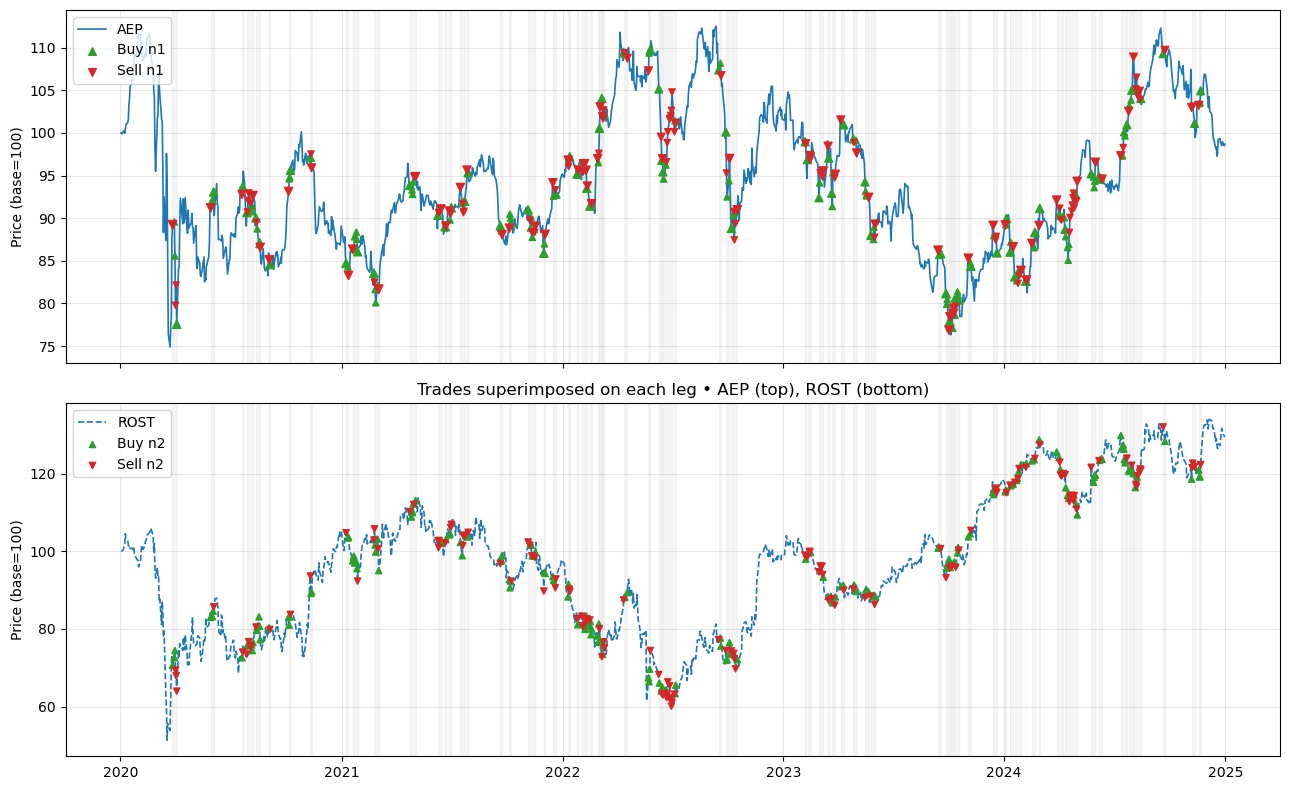

In [33]:
# df_pair: has P1,P2 columns (and optionally beta,y_hat)
# signals: from generate_pair_signals(...), has z,pos,n1,n2,entry,exit,stop

plot_pair_legs_with_trades(
    df_pair, signals,
    label1=ticker1, label2=ticker2,
    normalize=True, base_value=100,
    shade_positions=True,
    size_scale=0.004,   # tweak to taste based on your notional levels
    min_marker=20, max_marker=220
)


### Evaluate Performance of the Strategy

In [34]:
import numpy as np, pandas as pd

def evaluate_pair_signals(
    df_pair: pd.DataFrame,
    signals: pd.DataFrame,
    *,
    # cost model
    cost_bps: float = 0.0,            # commission+slippage, bps of traded notional (per leg)
    fee_per_share_1: float = 0.0,     # fixed fee per share for leg 1
    fee_per_share_2: float = 0.0,     # fixed fee per share for leg 2
    borrow_bps_per_year: float = 0.0, # short borrow (annual bps on short market value)
    days_per_year: int = 252,
    # return scaling
    capital_base: float | None = None # if None: median in-position gross exposure
):
    """
    Evaluate a single pair's executed signals (next-bar safe).
    Assumes signals has executed columns: ['pos','n1','n2'] (and optionally 'z','entry','exit','stop').

    Returns:
        daily  : DataFrame with pnl/returns/exposure/turnover
        trades : DataFrame of round-trip trades
        summary: dict of key metrics
    """
    # --- align & sanity ---
    cols = ["P1","P2"]
    df = pd.concat([df_pair[cols], signals], axis=1).copy()
    df = df.sort_index()
    # executed holdings
    n1 = df["n1"].astype(float).fillna(0.0)
    n2 = df["n2"].astype(float).fillna(0.0)
    pos = (np.sign(n1) != 0) | (np.sign(n2) != 0)

    # --- price changes (close-to-close PnL with *executed* holdings) ---
    dP1 = df["P1"].astype(float).diff().fillna(0.0)
    dP2 = df["P2"].astype(float).diff().fillna(0.0)
    pnl_gross = n1 * dP1 + n2 * dP2

    # --- trades and costs ---
    dn1 = n1.diff().fillna(n1)  # Δshares (entry/exit/rebalance on this bar)
    dn2 = n2.diff().fillna(n2)
    traded_notional = (dn1.abs() * df["P1"]) + (dn2.abs() * df["P2"])
    cost_comm_slip  = (cost_bps / 1e4) * traded_notional
    cost_per_share  = fee_per_share_1 * dn1.abs() + fee_per_share_2 * dn2.abs()

    short_notional = (np.where(n1 < 0, -n1 * df["P1"], 0.0)
                    + np.where(n2 < 0, -n2 * df["P2"], 0.0))
    cost_borrow = short_notional * (borrow_bps_per_year / 1e4) / days_per_year

    cost_total = cost_comm_slip + cost_per_share + cost_borrow
    pnl_net = pnl_gross - cost_total

    # --- exposures & returns ---
    gross_exposure = n1.abs() * df["P1"] + n2.abs() * df["P2"]
    net_exposure   = n1 * df["P1"] + n2 * df["P2"]

    if capital_base is None:
        # typical scale used during sizing; robust to outliers
        capital_base = float(np.nanmedian(gross_exposure.where(pos)))
        if not np.isfinite(capital_base) or capital_base <= 0:
            capital_base = 1.0

    ret_net = pnl_net / capital_base
    equity  = pnl_net.cumsum()

    # --- NEW: portfolio value & drawdowns on portfolio, not equity ---
    portfolio = capital_base + equity
    peak_port = portfolio.cummax()
    dd = portfolio - peak_port
    dd_pct = (portfolio / peak_port - 1.0).replace([-np.inf, np.inf], 0.0).fillna(0.0)
    # ----------------------------------------------------------------

    # --- turnover ---
    daily_turnover = traded_notional / capital_base

    daily = pd.DataFrame({
        "pnl_gross": pnl_gross,
        "cost": cost_total,
        "pnl_net": pnl_net,
        "ret_net": ret_net,
        "equity": equity,
        "portfolio": portfolio,        # NEW: convenient to inspect
        "gross_exposure": gross_exposure,
        "net_exposure": net_exposure,
        "turnover": daily_turnover,
        "in_pos": pos.astype(int),
        "drawdown": dd,                # moved here after portfolio calc
        "drawdown_pct": dd_pct,
    })

    # --- per-trade breakdown (round trips) ---
    entries = daily.index[(pos) & (~pos.shift(1, fill_value=False))]
    exits   = daily.index[(~pos) & (pos.shift(1, fill_value=False))]
    trade_rows = []
    for i, start in enumerate(entries):
        after = exits[exits > start]
        if len(after) == 0:
            break
        end = after[0]
        sl = daily.loc[start:end].iloc[:-1]  # exclude the flat bar at 'end'
        if sl.empty:
            continue
        side = int(np.sign(n1.loc[start]) or np.sign(n2.loc[start]))  # +1 long-spread, -1 short-spread
        pnl_g = sl["pnl_gross"].sum()
        cost  = sl["cost"].sum()
        pnl_n = sl["pnl_net"].sum()
        ret   = sl["ret_net"].sum()
        hold  = sl.shape[0]
        z_e   = df["z"].loc[start] if "z" in df else np.nan
        z_x   = df["z"].shift(1).loc[end] if "z" in df else np.nan  # decision z day before exit exec
        trade_rows.append({
            "entry": start, "exit": end, "side": side,
            "bars": hold, "pnl_gross": pnl_g, "cost": cost, "pnl_net": pnl_n, "ret_on_cap": ret,
            "z_at_entry": z_e, "z_prev_exit": z_x
        })
    trades = pd.DataFrame(trade_rows)
    if not trades.empty:
        wins = trades["pnl_net"] > 0
        profit_factor = (trades.loc[wins, "pnl_net"].sum() /
                         -trades.loc[~wins, "pnl_net"].sum()) if (~wins).any() else np.inf
        avg_hold = trades["bars"].mean()
        med_hold = trades["bars"].median()
        hitrate  = wins.mean()
        avg_win  = trades.loc[wins, "pnl_net"].mean() if wins.any() else 0.0
        avg_loss = trades.loc[~wins, "pnl_net"].mean() if (~wins).any() else 0.0
    else:
        profit_factor = np.nan; avg_hold = med_hold = hitrate = avg_win = avg_loss = np.nan

    # --- summary metrics ---
    n = daily.shape[0]
    ret_mean = daily["ret_net"].mean()
    ret_std  = daily["ret_net"].std(ddof=0)
    sharpe   = (ret_mean / ret_std) * np.sqrt(days_per_year) if ret_std > 0 else np.nan
    ann_ret  = (1.0 + daily["ret_net"].fillna(0)).prod() ** (days_per_year / max(n,1)) - 1.0
    ann_turnover = daily["turnover"].sum() * (days_per_year / max(n,1))
    mdd = float(-dd.min())                    # absolute drawdown (dollars)
    mdd_pct = float(-dd_pct.min())            # percentage drawdown on portfolio
    exposure_util = daily.loc[pos, "gross_exposure"].mean() / capital_base if pos.any() else 0.0

    summary = {
        "start": daily.index[0] if n else None,
        "end":   daily.index[-1] if n else None,
        "bars": n,
        "capital_base": capital_base,
        "gross_pnl": float(daily["pnl_gross"].sum()),
        "net_pnl": float(daily["pnl_net"].sum()),
        "ann_return": float(ann_ret),
        "sharpe": float(sharpe),
        "max_drawdown": mdd,
        "max_drawdown_pct": mdd_pct,
        "avg_gross_exposure": float(daily["gross_exposure"].mean()),
        "avg_exposure_utilization": float(exposure_util),
        "turnover_annualized": float(ann_turnover),
        "n_trades": int(len(trades)),
        "hit_rate": float(hitrate) if not np.isnan(hitrate) else np.nan,
        "avg_win": float(avg_win) if not np.isnan(avg_win) else np.nan,
        "avg_loss": float(avg_loss) if not np.isnan(avg_loss) else np.nan,
        "profit_factor": float(profit_factor) if np.isfinite(profit_factor) else np.inf,
        "avg_hold_bars": float(avg_hold) if not np.isnan(avg_hold) else np.nan,
        "med_hold_bars": float(med_hold) if not np.isnan(med_hold) else np.nan,
    }

    return daily, trades, summary


### Evaluate Performance on the training data

In [35]:
# df_pair has P1,P2; signals are your executed outputs (with next-bar logic)
daily, trades, summary = evaluate_pair_signals(
    df_pair, signals,
    cost_bps=1.0,                 # e.g., 1bp per side total (commission+slippage)
    fee_per_share_1=0.0, fee_per_share_2=0.0,
    borrow_bps_per_year=50.0,     # optional short borrow, e.g., 50 bps/year
    capital_base=10_000           # same as used when sizing n1/n2 (recommended)
)

print(pd.Series(summary))
# daily[['pnl_net','equity','drawdown_pct']].tail()
# trades.head()


start                        2020-01-02
end                          2024-12-31
bars                               1258
capital_base                      10000
gross_pnl                   -187.432031
net_pnl                     -352.476517
ann_return                    -0.010688
sharpe                        -0.082178
max_drawdown                1670.861538
max_drawdown_pct               0.155623
avg_gross_exposure          1963.182753
avg_exposure_utilization       0.999872
turnover_annualized           28.859562
n_trades                             70
hit_rate                       0.542857
avg_win                      116.138093
avg_loss                    -146.737913
profit_factor                  0.939866
avg_hold_bars                  3.528571
med_hold_bars                       3.0
dtype: object


### Evaluate Trained Strategy on (Fressh, Unseen) Test Data

In [36]:
start_test="2025-01-02"
end_test="2025-08-14"

In [37]:
df_test, failed = download_history_openbb([ticker1, ticker2], start_test, end_test, return_failed=True)

print(df_test.head())
if failed:
    print("No data for:", failed)


AEP:   0%|          | 0/2 [00:00<?, ?it/s]     

ROST: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                 open       high        low      close   volume  dividend  \
date                                                                        
2025-01-02  92.570000  93.230003  91.589996  91.940002  1757200       0.0   
2025-01-03  92.400002  93.059998  92.029999  92.050003  1688400       0.0   
2025-01-06  92.050003  92.050003  90.010002  90.320000  3457200       0.0   
2025-01-07  90.099998  91.910004  90.099998  90.470001  2706000       0.0   
2025-01-08  90.250000  92.349998  89.910004  92.260002  2591500       0.0   

           ticker  
date               
2025-01-02    AEP  
2025-01-03    AEP  
2025-01-06    AEP  
2025-01-07    AEP  
2025-01-08    AEP  


In [38]:
import numpy as np, pandas as pd
from pykalman import KalmanFilter

def _build_H(x: np.ndarray) -> np.ndarray:
    """Time-varying observation matrix H_t = [[x_t, 1]] for each t."""
    n = len(x)
    H = np.zeros((n, 1, 2), dtype=float)
    H[:, 0, 0] = x
    H[:, 0, 1] = 1.0
    return H

def fit_kf_train(P1_train: pd.Series, P2_train: pd.Series, *,
                 q: float = 1e-5, r: float = 1.0, init_cov: float = 1e6,
                 em_iters: int = 10):
    """Fit on a training window; return frozen params and last filtered state."""
    y = P1_train.values.reshape(-1, 1)
    x = P2_train.values
    H = _build_H(x)
    F = np.eye(2)

    kf = KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        initial_state_mean=np.array([0.0, 0.0]),      # [beta0, alpha0]
        initial_state_covariance=np.eye(2) * init_cov,
        transition_covariance=np.eye(2) * q,
        observation_covariance=np.array([[r]], float),
    )
    if em_iters and em_iters > 0:
        kf = kf.em(y, n_iter=em_iters)

    # FILTER (causal)
    state_means, state_covs = kf.filter(y)

    frozen = {
        "F": F,
        "Q": kf.transition_covariance.copy(),
        "R": kf.observation_covariance.copy(),
    }
    last_state = (state_means[-1].copy(), state_covs[-1].copy())  # (mean, cov)
    return frozen, last_state

def filter_kf_on_new(P1_new: pd.Series, P2_new: pd.Series, *,
                     frozen: dict, last_state: tuple | None = None,
                     init_cov: float = 1e6):
    """Apply frozen params to new data; return filtered alpha_t, beta_t, resid."""
    y = P1_new.values.reshape(-1, 1)
    x = P2_new.values
    H = _build_H(x)
    F, Q, R = frozen["F"], frozen["Q"], frozen["R"]

    if last_state is None:
        m0 = np.array([0.0, 0.0])
        P0 = np.eye(2) * init_cov   # diffuse start
    else:
        m0, P0 = last_state

    kf = KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        initial_state_mean=m0,
        initial_state_covariance=P0,
        transition_covariance=Q,
        observation_covariance=R,
    )
    state_means, state_covs = kf.filter(y)  # causal only

    beta_t  = state_means[:, 0]
    alpha_t = state_means[:, 1]
    y_hat   = alpha_t + beta_t * x
    resid   = P1_new.values - y_hat

    out = pd.DataFrame(
        {"alpha": alpha_t, "beta": beta_t, "y_hat": y_hat, "resid": resid},
        index=P1_new.index,
    )
    return out, (state_means[-1], state_covs[-1])  # also return final state for chaining


In [39]:
# pick the pair you trained
pair = (ticker1, ticker2)

# freeze hyperparameters learned on TRAIN
frozen = {
    "F": params_tr[pair]["F"],
    "Q": params_tr[pair]["Q"],
    "R": params_tr[pair]["R"],
}

# start the new run from the last *filtered* TRAIN state (or use None for diffuse)
last_state = (params_tr[pair]["last_state_mean"], params_tr[pair]["last_state_cov"])

# make sure P1_new, P2_new are aligned and share the same DateTimeIndex
P1_new = df_test[df_test['ticker']==ticker1]['close']
P2_new = df_test[df_test['ticker']==ticker2]['close']

df_new_states, last_state = filter_kf_on_new(
    P1_new, P2_new,
    frozen=frozen,
    last_state=last_state,   # or None if this is a disjoint start
    init_cov=1e6
)

# df_new_states has ['alpha','beta','y_hat','resid'] for the new period


In [40]:
df_new_states.head()

,alpha,beta,y_hat,resid
date,,,,
2025-01-02,71.555946,0.135168,92.182549,-0.242546
2025-01-03,71.556241,0.133386,92.130994,-0.080991
2025-01-06,71.556954,0.123682,90.721499,-0.401499
2025-01-07,71.557152,0.124547,90.433453,0.036549
2025-01-08,71.556019,0.131934,91.956975,0.303027


In [41]:
df_pair_test = pd.DataFrame({
    'P1': P1_new,
    'P2': P2_new
}).join(df_new_states[['beta', 'resid']])

In [42]:
signals_test = generate_pair_signals(
    df_pair_test,
    z_method="robust",
    z_entry=2.0, z_exit=0.5, z_stop=4.0,
    capital_per_pair=10_000,
    max_hold_bars=None,            # set like 3*estimate_halflife(df_pair['resid'])
    cooldown_bars=0
)

(<Figure size 1300x800 with 2 Axes>,
 (<Axes: ylabel='Price (base=100)'>,
  <Axes: title={'center': 'Trades superimposed on each leg • AEP (top), ROST (bottom)'}, ylabel='Price (base=100)'>))

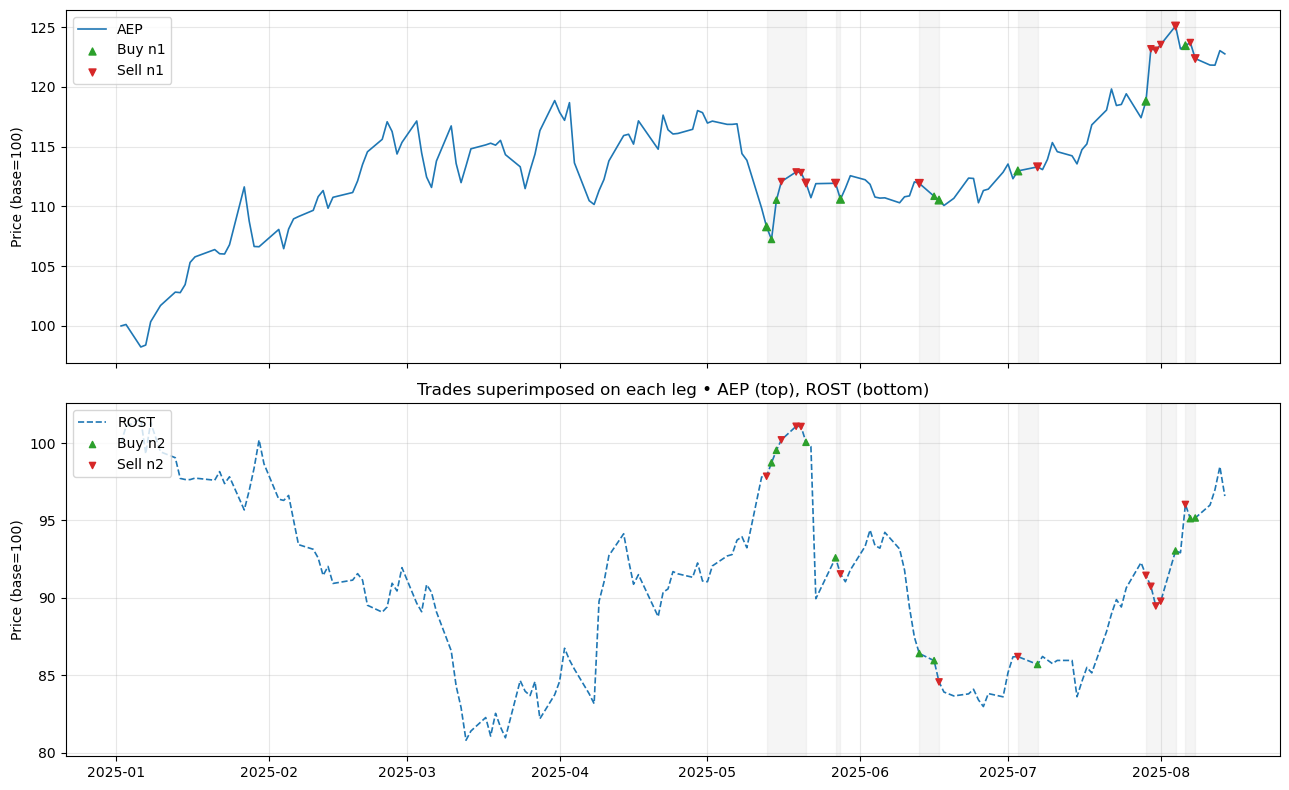

In [43]:
# df_pair: has P1,P2 columns (and optionally beta,y_hat)
# signals: from generate_pair_signals(...), has z,pos,n1,n2,entry,exit,stop

plot_pair_legs_with_trades(
    df_pair_test, signals_test,
    label1=ticker1, label2=ticker2,
    normalize=True, base_value=100,
    shade_positions=True,
    size_scale=0.004,   # tweak to taste based on your notional levels
    min_marker=20, max_marker=220
)


In [44]:
# df_pair has P1,P2; signals are your executed outputs (with next-bar logic)
daily_test, trades_test, summary_test = evaluate_pair_signals(
    df_pair_test, signals_test,
    cost_bps=1.0,                 # e.g., 1bp per side total (commission+slippage)
    fee_per_share_1=0.0, fee_per_share_2=0.0,
    borrow_bps_per_year=50.0,     # optional short borrow, e.g., 50 bps/year
    capital_base=10_000           # same as used when sizing n1/n2 (recommended)
)

print(pd.Series(summary_test))
# daily[['pnl_net','equity','drawdown_pct']].tail()
# trades.head()

start                        2025-01-02
end                          2025-08-14
bars                                154
capital_base                      10000
gross_pnl                    713.910702
net_pnl                      700.610271
ann_return                      0.11968
sharpe                          2.02925
max_drawdown                 206.466108
max_drawdown_pct               0.020647
avg_gross_exposure          1043.447397
avg_exposure_utilization       1.004318
turnover_annualized           19.981891
n_trades                              6
hit_rate                       0.833333
avg_win                      148.220988
avg_loss                     -34.503578
profit_factor                 21.479075
avg_hold_bars                  2.666667
med_hold_bars                       2.0
dtype: object
